In [ ]:
import os
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import sys
sys.path.insert(0, "../code")   
from model_utils import train


In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
# load
df = pd.read_pickle("../output/data/scaled_train_nonoverlap_top_10_store_item_X_y.pkl")
df.head()

,date,store_item,item_nbr,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,sales_day_7,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
9,2013-01-07,3_1047679,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,0.642623,...,0.248855,0.293631,0.373440,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
109,2013-01-14,3_1047679,1047679,0.370635,0.099245,0.067611,0.029903,0.287365,0.652988,0.554918,...,0.233335,0.264983,0.296819,0.434836,0.191950,0.206373,0.272727,0.214570,0.282750,0.514180
209,2013-01-21,3_1047679,1047679,0.461111,0.074649,0.086751,0.156117,0.161733,0.463872,0.388525,...,0.379813,0.355046,0.342084,0.080390,0.199690,0.147193,0.196970,0.209272,0.363165,0.329223
309,2013-01-28,3_1047679,1047679,0.199206,0.065156,0.071588,0.128932,0.391336,0.333631,0.526230,...,0.225370,0.306709,0.184635,0.225335,0.202786,0.209408,0.225379,0.182781,0.225681,0.124538
409,2013-02-04,3_1047679,1047679,0.247619,0.076160,0.065374,0.104854,0.340072,0.325602,0.200820,...,0.309908,0.354130,0.308045,0.152253,0.241486,0.210926,0.170455,0.135099,0.172503,0.186190


In [5]:
df.columns

Index(['date', 'store_item', 'item_nbr', 'sales_day_1', 'sales_day_2',
       'sales_day_3', 'sales_day_4', 'sales_day_5', 'sales_day_6',
       'sales_day_7', 'store_med_day_1', 'store_med_day_2', 'store_med_day_3',
       'store_med_day_4', 'store_med_day_5', 'store_med_day_6',
       'store_med_day_7', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3',
       'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7',
       'y_sales_day_1', 'y_sales_day_2', 'y_sales_day_3', 'y_sales_day_4',
       'y_sales_day_5', 'y_sales_day_6', 'y_sales_day_7', 'y_store_med_day_1',
       'y_store_med_day_2', 'y_store_med_day_3', 'y_store_med_day_4',
       'y_store_med_day_5', 'y_store_med_day_6', 'y_store_med_day_7',
       'y_item_med_day_1', 'y_item_med_day_2', 'y_item_med_day_3',
       'y_item_med_day_4', 'y_item_med_day_5', 'y_item_med_day_6',
       'y_item_med_day_7'],
      dtype='object')

In [57]:
feature_cols = (
    [f"sales_day_{i}"     for i in range(1, 8)]  # 7 cols
  + [f"store_med_day_{i}" for i in range(1, 8)]  # 7 cols
  + [f"item_med_day_{i}"  for i in range(1, 8)]  # 7 cols
)
label_cols = (
    [f"y_sales_day_{i}"     for i in range(1,8)]
  + [f"y_store_med_day_{i}" for i in range(1,8)]
  + [f"y_item_med_day_{i}"  for i in range(1,8)]
)
# # … shift & drop to build X, y …
# df = df.dropna(subset=[f'y_{c}' for c in feature_cols]).reset_index(drop=True)

# # now build groups:
# groups = df['store_item'].values      # e.g. array(['3_1047679', '5_2093842', …], dtype=object)

# # if you really need integer labels, you can factorize:
# group_ids, groups_idx = np.unique(groups, return_inverse=True)
# # groups_idx is then an array of 0..(num_groups‑1)

# X = df[feature_cols].to_numpy()          # shape (N, 21)
# y = df[[f"y_{c}" for c in feature_cols]].to_numpy()  # shape (N, 21)

In [58]:
df.head()

,date,store_item,item_nbr,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,sales_day_7,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,0.642623,...,0.248855,0.293631,0.373440,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-14,3_1047679,1047679,0.370635,0.099245,0.067611,0.029903,0.287365,0.652988,0.554918,...,0.233335,0.264983,0.296819,0.434836,0.191950,0.206373,0.272727,0.214570,0.282750,0.514180
2,2013-01-21,3_1047679,1047679,0.461111,0.074649,0.086751,0.156117,0.161733,0.463872,0.388525,...,0.379813,0.355046,0.342084,0.080390,0.199690,0.147193,0.196970,0.209272,0.363165,0.329223
3,2013-01-28,3_1047679,1047679,0.199206,0.065156,0.071588,0.128932,0.391336,0.333631,0.526230,...,0.225370,0.306709,0.184635,0.225335,0.202786,0.209408,0.225379,0.182781,0.225681,0.124538
4,2013-02-04,3_1047679,1047679,0.247619,0.076160,0.065374,0.104854,0.340072,0.325602,0.200820,...,0.309908,0.354130,0.308045,0.152253,0.241486,0.210926,0.170455,0.135099,0.172503,0.186190


In [59]:
df.columns


Index(['date', 'store_item', 'item_nbr', 'sales_day_1', 'sales_day_2',
       'sales_day_3', 'sales_day_4', 'sales_day_5', 'sales_day_6',
       'sales_day_7', 'store_med_day_1', 'store_med_day_2', 'store_med_day_3',
       'store_med_day_4', 'store_med_day_5', 'store_med_day_6',
       'store_med_day_7', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3',
       'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7',
       'y_sales_day_1', 'y_sales_day_2', 'y_sales_day_3', 'y_sales_day_4',
       'y_sales_day_5', 'y_sales_day_6', 'y_sales_day_7', 'y_store_med_day_1',
       'y_store_med_day_2', 'y_store_med_day_3', 'y_store_med_day_4',
       'y_store_med_day_5', 'y_store_med_day_6', 'y_store_med_day_7',
       'y_item_med_day_1', 'y_item_med_day_2', 'y_item_med_day_3',
       'y_item_med_day_4', 'y_item_med_day_5', 'y_item_med_day_6',
       'y_item_med_day_7'],
      dtype='object')

In [60]:
weights_df= pd.read_csv("../output/data/top_10_store_10_item_weights.csv")

In [61]:
weights_df

,item_nbr,weight
0,96995,1.00
1,99197,1.00
2,103501,1.00
3,103520,1.00
4,103665,1.25
...,...,...
4095,2132318,1.00
4096,2132945,1.00
4097,2132957,1.00
4098,2134058,1.00


In [65]:
df.head()

,date,store_item,item_nbr,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,sales_day_7,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,0.642623,...,0.248855,0.293631,0.373440,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-14,3_1047679,1047679,0.370635,0.099245,0.067611,0.029903,0.287365,0.652988,0.554918,...,0.233335,0.264983,0.296819,0.434836,0.191950,0.206373,0.272727,0.214570,0.282750,0.514180
2,2013-01-21,3_1047679,1047679,0.461111,0.074649,0.086751,0.156117,0.161733,0.463872,0.388525,...,0.379813,0.355046,0.342084,0.080390,0.199690,0.147193,0.196970,0.209272,0.363165,0.329223
3,2013-01-28,3_1047679,1047679,0.199206,0.065156,0.071588,0.128932,0.391336,0.333631,0.526230,...,0.225370,0.306709,0.184635,0.225335,0.202786,0.209408,0.225379,0.182781,0.225681,0.124538
4,2013-02-04,3_1047679,1047679,0.247619,0.076160,0.065374,0.104854,0.340072,0.325602,0.200820,...,0.309908,0.354130,0.308045,0.152253,0.241486,0.210926,0.170455,0.135099,0.172503,0.186190


In [ ]:
# import os
# import torch
# import pandas as pd
# from torch.utils.data import TensorDataset, DataLoader
# from typing import List, Tuple, Dict

# def train(
#     df: pd.DataFrame,
#     weights_df: pd.DataFrame,
#     feature_cols: List[str],
#     label_cols:   List[str],
#     item_col:     str,
#     train_frac:   float  = 0.8,
#     batch_size:   int    = 32,
#     lr:           float  = 1e-3,
#     epochs:       int    = 5,
#     seed:         int    = 2025,
#     model_dir:    str    = "../output/models/",
# ) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, torch.nn.Module]]:
#     """
#     Trains a separate ShallowNN on each store_item's time series (no CV),
#     does an 80/20 split by time, saves each model, and returns:
#       - hist_df: per-epoch train/test losses
#       - summary_df: final losses by store_item
#       - models: dict mapping store_item -> trained model (on CPU)
#     """
#     torch.manual_seed(seed)
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     os.makedirs(model_dir, exist_ok=True)

#     history = []
#     models: Dict[str, torch.nn.Module] = {}

#     for sid in df['store_item'].unique():
#         # --- Prepare sid-specific data
#         sub = (df[df['store_item']==sid]
#                .sort_values('date')
#                .reset_index(drop=True)
#                .merge(weights_df, on=item_col, how='left'))

#         X = sub[feature_cols].to_numpy(float)
#         y = sub[label_cols].to_numpy(float)
#         w = sub['weight'].to_numpy(float).reshape(-1,1)

#         # train/test 80/20 by time
#         train_size = int(len(sub) * train_frac)
#         X_tr, X_te = X[:train_size], X[train_size:]
#         y_tr, y_te = y[:train_size], y[train_size:]
#         w_tr, w_te = w[:train_size], w[train_size:]

#         # DataLoaders
#         ds_tr = TensorDataset(torch.from_numpy(X_tr).float(),
#                               torch.from_numpy(y_tr).float(),
#                               torch.from_numpy(w_tr).float())
#         ds_te = TensorDataset(torch.from_numpy(X_te).float(),
#                               torch.from_numpy(y_te).float(),
#                               torch.from_numpy(w_te).float())
#         ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=False)
#         ld_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False)

#         # init model, loss, optimizer
#         model   = ShallowNN(input_dim=len(feature_cols)).to(device)
#         loss_fn = NWRMSLELoss()
#         optim   = torch.optim.Adam(model.parameters(), lr=lr)

#         # train epochs
#         for epoch in range(1, epochs+1):
#             # train
#             model.train()
#             tr_loss_acc = 0.0
#             for xb,yb,wb in ld_tr:
#                 xb,yb,wb = xb.to(device), yb.to(device), wb.to(device)
#                 preds = model(xb)
#                 loss  = loss_fn(preds, yb, wb)
#                 optim.zero_grad(); loss.backward(); optim.step()
#                 tr_loss_acc += loss.item()*xb.size(0)
#             tr_loss = tr_loss_acc / len(ds_tr)

#             # test
#             model.eval()
#             num, den = 0.0, 0.0
#             with torch.no_grad():
#                 for xb,yb,wb in ld_te:
#                     xb,yb,wb = xb.to(device), yb.to(device), wb.to(device)
#                     p = model(xb).clamp(min=1e-6)
#                     ld = torch.log(p+1) - torch.log(yb+1)
#                     num += (wb*ld**2).sum().item()
#                     den += wb.sum().item()
#             te_loss = (num/den)**0.5

#             history.append({
#                 'store_item': sid,
#                 'epoch':      epoch,
#                 'train_loss': tr_loss,
#                 'test_loss':  te_loss
#             })
#             print(f"[{sid}] Epoch {epoch}/{epochs} — train {tr_loss:.4f}, test {te_loss:.4f}")

#         # save to disk
#         save_path = os.path.join(model_dir, f"model_{sid}.pth")
#         torch.save({
#             'sid': sid,
#             'model_state_dict': model.cpu().state_dict(),
#             'feature_cols':     feature_cols,
#             'label_cols':       label_cols,
#             'train_frac':       train_frac,
#             'epochs':           epochs,
#         }, save_path)
#         print(f"Saved model for {sid} to {save_path}")

#         # keep in memory (on CPU) as well
#         models[sid] = model.cpu()

#     # build DataFrames
#     hist_df = pd.DataFrame(history)
#     summary_df = (
#         hist_df
#         .groupby('store_item')
#         .agg(final_train_loss=('train_loss','last'),
#              final_test_loss =('test_loss','last'))
#         .reset_index()
#     )

#     return hist_df, summary_df, models


In [71]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [72]:
# df2= df.query('store_item == "3_1047679"')
# df2

In [78]:
hist_df, summary_df, models_dict = train(
    df            = df,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    item_col      = "item_nbr",
    train_frac    = 0.8,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 50,
    seed          = 2025,
    model_dir     = "../output/models/"
)

[3_1047679] Epoch 1/50 — train 0.8259, test 0.8552
[3_1047679] Epoch 2/50 — train 0.7692, test 0.8003
[3_1047679] Epoch 3/50 — train 0.7106, test 0.7408
[3_1047679] Epoch 4/50 — train 0.6477, test 0.6760
[3_1047679] Epoch 5/50 — train 0.5821, test 0.6091
[3_1047679] Epoch 6/50 — train 0.5210, test 0.5479
[3_1047679] Epoch 7/50 — train 0.4738, test 0.5001
[3_1047679] Epoch 8/50 — train 0.4443, test 0.4677
[3_1047679] Epoch 9/50 — train 0.4274, test 0.4472
[3_1047679] Epoch 10/50 — train 0.4165, test 0.4353
[3_1047679] Epoch 11/50 — train 0.4088, test 0.4297
[3_1047679] Epoch 12/50 — train 0.4039, test 0.4276
[3_1047679] Epoch 13/50 — train 0.4007, test 0.4267
[3_1047679] Epoch 14/50 — train 0.3984, test 0.4257
[3_1047679] Epoch 15/50 — train 0.3966, test 0.4245
[3_1047679] Epoch 16/50 — train 0.3950, test 0.4233
[3_1047679] Epoch 17/50 — train 0.3936, test 0.4223
[3_1047679] Epoch 18/50 — train 0.3923, test 0.4215
[3_1047679] Epoch 19/50 — train 0.3909, test 0.4210
[3_1047679] Epoch 20/

In [79]:
hist_df.head(3)


,store_item,epoch,train_loss,test_loss
0,3_1047679,1,0.825924,0.855200
1,3_1047679,2,0.769211,0.800326
2,3_1047679,3,0.710638,0.740825


In [80]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss
0,3_1047679,0.343407,0.411792
1,3_114790,0.176714,0.265950
2,3_305229,0.189679,0.198183


In [90]:


def plot_loss_per_sid(hist_df, sid, fn):
    """
    Plot train and test loss vs. epoch for a given store_item (sid),
    save to file `fn`.
    """
    df = hist_df[hist_df["store_item"] == sid].sort_values("epoch")
    if df.empty:
        raise ValueError(f"No data found for store_item = {sid!r}")

    fig, ax = plt.subplots(figsize=(12, 5))

    # plot
    ax.plot(df["epoch"], df["train_loss"], marker="o", label="Train Loss")
    ax.plot(df["epoch"], df["test_loss"],  marker="o", label="Validation Loss")

    # titles & labels
    ax.set_title(f"Loss Curves for {sid}", fontsize=24, fontweight="bold")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

    # ticks exactly at each epoch
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(df["epoch"].min(), df["epoch"].max())  # clamp x-axis

    # y-axis ticks
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))

    # grid, legend
    ax.grid(True, which="major", linestyle="--", alpha=0.5)
    ax.legend()

    # tick styling
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='major', length=6)
    ax.tick_params(axis='y', which='minor', length=4)

    plt.tight_layout(pad=2)
    plt.savefig(fn, dpi=300)
    plt.show()
    plt.close(fig)


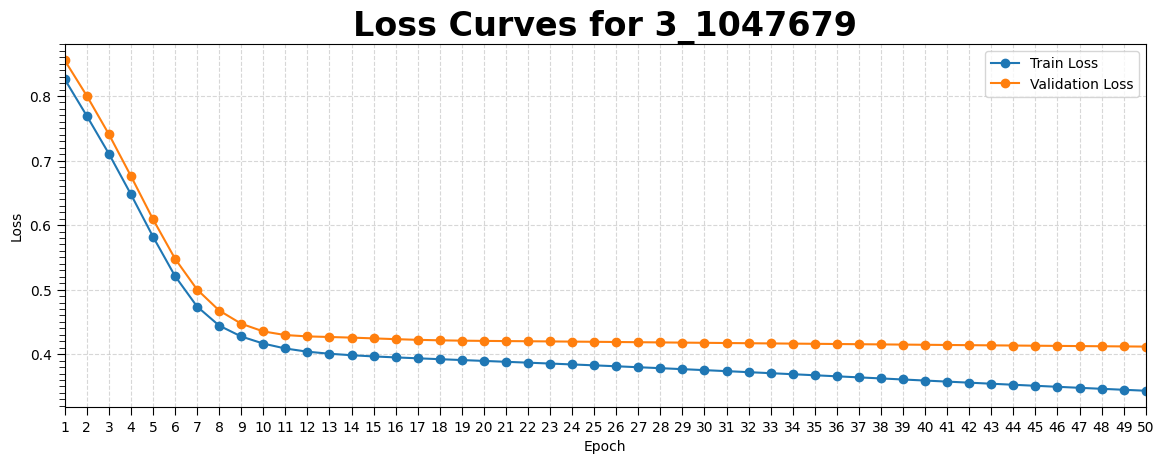

In [89]:
# to plot a single sid:
sid = "3_1047679"
plot_loss_per_sid(hist_df, sid=sid, fn=f"../output/figures/loss_curves_{sid}.tiff")

# # if you want to loop over all sids:
# for sid in hist_df["store_item"].unique():
#     plot_loss_per_sid(hist_df, sid)


In [102]:

def plot_all_sids_losses(hist_df, overall_title=None, fn=None):
    sids   = hist_df["store_item"].unique()
    epochs = sorted(hist_df["epoch"].unique())
    
    fig, (ax_tr, ax_te) = plt.subplots(2,1, figsize=(12,8), sharex=True)

    # — Train Loss —
    for sid in sids:
        df_sid = hist_df[hist_df["store_item"]==sid]
        ax_tr.plot(df_sid["epoch"], df_sid["train_loss"],
                   marker="o", linewidth=1, label=sid)
    ax_tr.set_title("Train Loss by Epoch", fontsize=16, fontweight="bold")
    ax_tr.set_ylabel("Train Loss")
    ax_tr.grid(True, linestyle="--", alpha=0.5)
    #ax_tr.legend(fontsize="small", ncol=2, bbox_to_anchor=(1.02,1), loc="best")

    # — Validation Loss —
    for sid in sids:
        df_sid = hist_df[hist_df["store_item"]==sid]
        ax_te.plot(df_sid["epoch"], df_sid["test_loss"],
                   marker="o", linewidth=1, label=sid)
    ax_te.set_title("Validation Loss by Epoch", fontsize=16, fontweight="bold")
    ax_te.set_xlabel("Epoch")
    ax_te.set_ylabel("Validation Loss")
    ax_te.grid(True, linestyle="--", alpha=0.5)
    #ax_te.legend(fontsize="small", ncol=2, bbox_to_anchor=(1.02,1), loc="best")

    # — Ticks every epoch, bigger & bold —
    for ax in (ax_tr, ax_te):
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.set_xlim(hist_df['epoch'].min(), hist_df['epoch'].max())  # Clamp x-axis
        # enlarge & bold tick labels
        for lbl in ax.get_xticklabels(which="major"):
            lbl.set_fontsize(10)
            lbl.set_fontweight("bold")
        for lbl in ax.get_yticklabels(which="major"):
            lbl.set_fontsize(10)
            lbl.set_fontweight("bold")

    # — Add overall title if provided —
    if overall_title:
        fig.suptitle(overall_title, fontsize=20, fontweight="bold")
        # tighten_layout will by default overlap the suptitle, so add this:
        plt.subplots_adjust(top=0.90)
        
    plt.tight_layout(pad=3)
    if fn:
        plt.savefig(fn, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

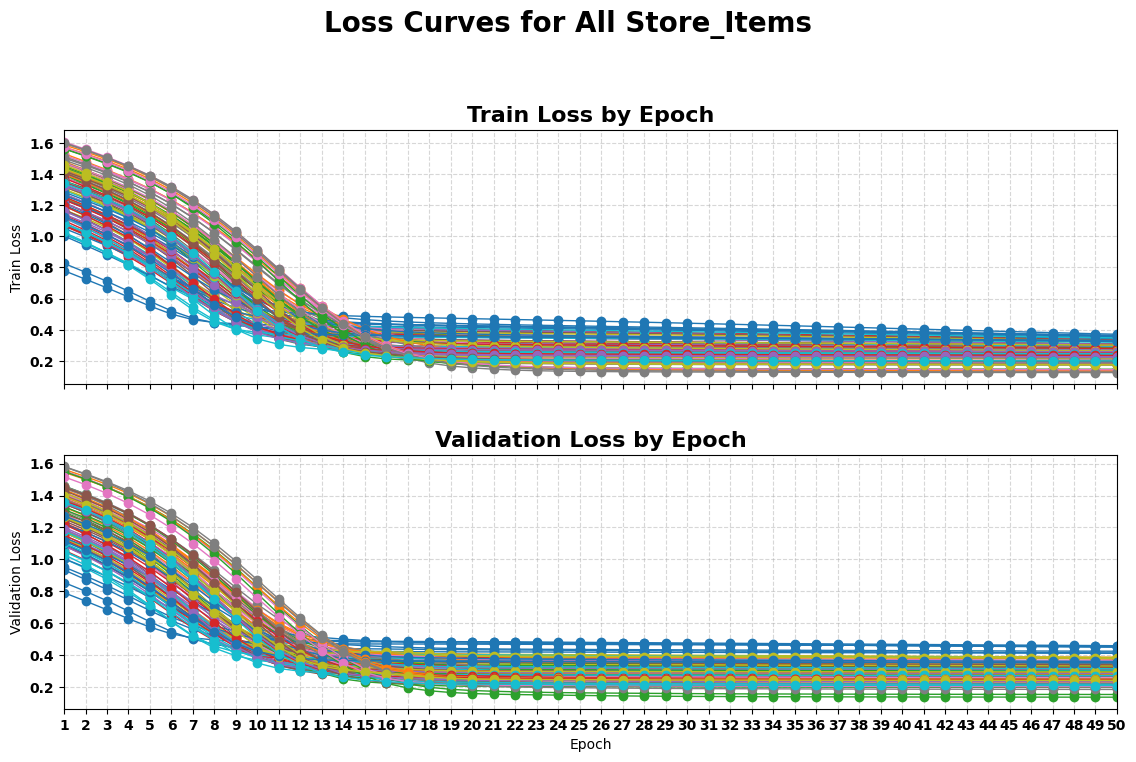

In [103]:
# Example usage:
plot_all_sids_losses(hist_df, 
                     overall_title="Loss Curves for All Store_Items",
fn=f"../output/figures/all_sids_loss_curves_.tiff")


In [ ]:

history_df = train_one_model_per_sid_kfold(
    df            = df,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    item_col      = 'item_nbr',
    k             = 5,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 50,
    shuffle       = True,
    seed          = 42,
)


In [31]:
history_df.head(20)

,store_item,fold,epoch,train_loss,val_loss
0,3_1047679,1,1,0.865164,0.843432
1,3_1047679,1,2,0.804671,0.783852
2,3_1047679,1,3,0.743904,0.721207
3,3_1047679,1,4,0.678408,0.652713
4,3_1047679,1,5,0.607657,0.581423
5,3_1047679,1,6,0.537030,0.516424
6,3_1047679,1,7,0.479141,0.468742
7,3_1047679,1,8,0.441573,0.441757
8,3_1047679,1,9,0.421774,0.426886
9,3_1047679,1,10,0.410583,0.417521


In [32]:
#history_df["store_item"].unique()

max_epoch: 50


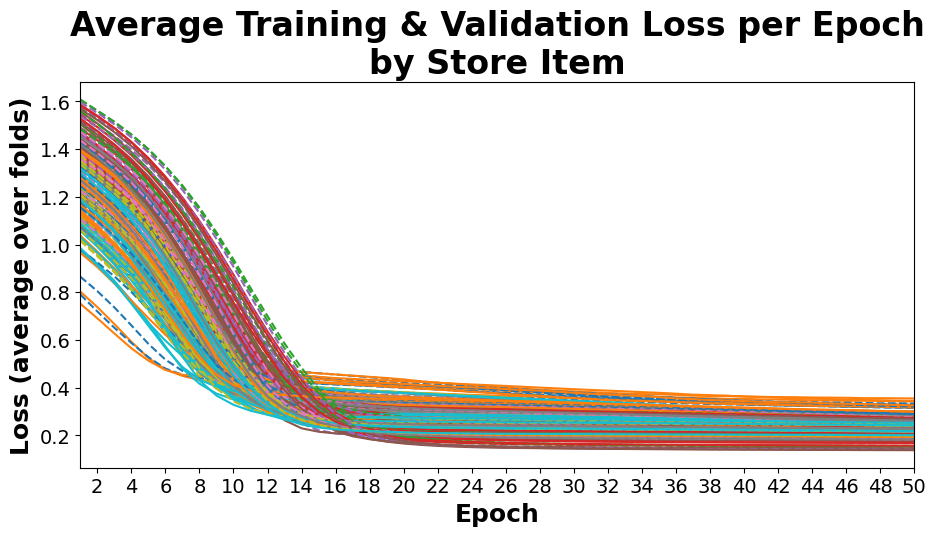

In [39]:
# 1) Compute per‐store, per‐epoch averages across folds
max_epoch = history_df['epoch'].max()
print(f"max_epoch: {max_epoch}")
# 1) Compute per‐store, per‐epoch averages across folds
avg_hist = (
    history_df
      .groupby(['store_item','epoch'], as_index=False)
      .agg({
          'train_loss': 'median',
          'val_loss':   'median'
      })
)
avg_hist = avg_hist[avg_hist['epoch'] <= max_epoch]


# 2) Plot
plt.figure(figsize=(10,6))


for sid, grp in avg_hist.groupby('store_item'):
    plt.plot(
        grp['epoch'], grp['train_loss'],
        linestyle='--', label=f'{sid} Train'
    )
    plt.plot(
        grp['epoch'], grp['val_loss'],
        linestyle='-', label=f'{sid} Val'
    )

plt.xlabel('Epoch', fontsize=18, fontweight="bold")
plt.ylabel('Loss (average over folds)', fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    'Average Training & Validation Loss per Epoch\nby Store Item',
    fontsize=24,       # or whatever size you prefer
    fontweight='bold'  # or weight='bold'
)

# limit x-axis
plt.xlim(1, max_epoch)
# set x‑axis major ticks every 2
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2))

# make legend font small
# plt.legend(
#     bbox_to_anchor=(1.01,1), loc='upper left', ncol=1,
#     fontsize=3       # or a numeric value like 8
# )
plt.tight_layout(pad=3.0)
plt.savefig("../output/figures/20250513_store_item_validation_loss.tiff", dpi=300, bbox_inches="tight")
plt.show()
plt.close() 



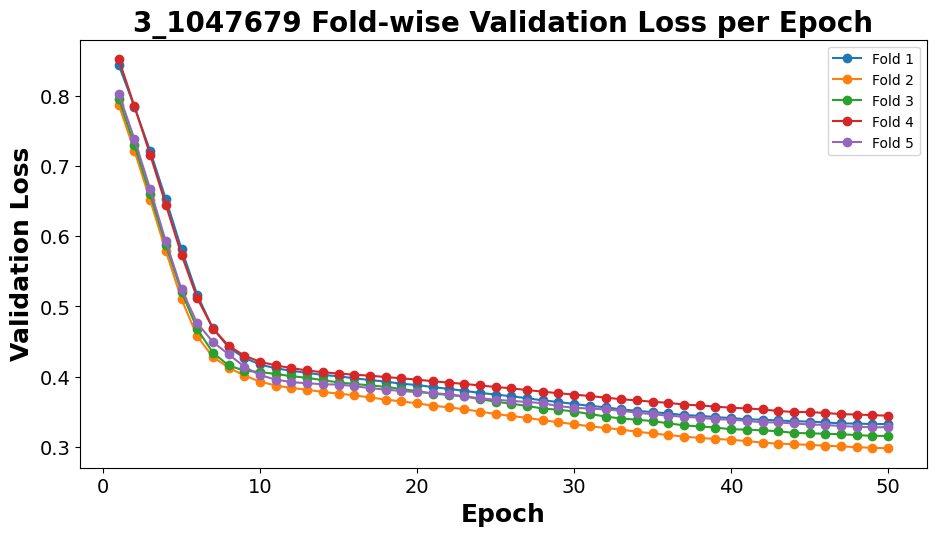

In [40]:
plt.figure(figsize=(10,6))
sid = "3_1047679"
h = history_df[history_df['store_item']==sid]

for fold, grp in h.groupby('fold'):
    # if fold == 4:
    #     continue
    plt.plot(
        grp['epoch'],
        grp['val_loss'],
        marker='o',
        label=f'Fold {fold}'
    )

plt.xlabel('Epoch', fontsize=18, fontweight="bold")
plt.ylabel('Validation Loss', fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(
    f'{sid} Fold‑wise Validation Loss per Epoch',
    fontsize=20,       
    fontweight='bold' 
)

plt.legend()
plt.tight_layout(pad=3.0)
plt.savefig("../output/figures/20250513_store_item_3_1047679_validation_loss.tiff", dpi=300, bbox_inches="tight")
plt.show()
plt.close() 

In [41]:
all_results

{'3_1047679': {'models': [ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
       (1): Tanh()
       (2): Linear(in_features=64, out_features=21, bias=True)
       (3): Sigmoid()
     )
   ),
   ShallowNN(
     (net): Sequential(
       (0): Linear(in_features=21, out_features=64, bias=True)
    